# Calibrate and triangulate data from multiple Sleap networks

(latest version on Github at https://github.com/tytell/tytell-lab.git)
This file from commit $Id$

Reequires (`sleap`)[https://sleap.ai/index.html] and `aniposelib` (version 0.6.1 or higher). Follow the directions to set up Sleap. Then  install `aniposelib` in the same python environment as Sleap: 
> % conda activate sleap

> % python -m pip install aniposelib

In [153]:
import os
import aniposelib
import pandas as pd
import numpy as np
import aniposelib
import cv2
import matplotlib.pyplot as plt
import re
from copy import copy

Skip down to the Sleap section if you've already done the calibration and have the `.toml` file.

Set up to detect a CHaRuCO board. Make sure you identify the number of squares and their size in mm. The numbers below should be correct for the board we have in the lab.

`marker_length`, `marker_bits`, and `dict_size` are particular to the sort of CHaRuCO board that we have in the lab. Don't change them unless you know what you're doing.

In [2]:
nsquaresx = 6
nsquaresy = 6

board = aniposelib.boards.CharucoBoard(squaresX=nsquaresx, squaresY=nsquaresy,
                                        square_length=24.33, marker_length=17, marker_bits=5, dict_size=50)

Fill in the path and the names of video files that have the CHaRuCO images. For paths on Windows machines, be careful not to remove the `r` at the beginning of the quote; without it, all backslashes will be registered as special characters.

In [214]:
videopath = r'/Users/etytel01/Documents/2024/StephenAcceleration/sleap/Pumpkinseed/11.15.23/11.15.23Calibration'
videonames = ['Charuco_camA.mp4', 'Charuco_camB.mp4', 'Charuco_camC.mp4']

# videopath = r'Raw data'
# videonames = ['9.5.22Calib-camA.mp4', '9.5.22Calib-camB.mp4', '9.5.22Calib-camC.mp4']

This will detect points in the first video, just for testing purposes.

In [4]:
video1 = os.path.join(videopath, videonames[0])
rows = board.detect_video(video1, progress=True)

100%|███████████████████████████████| 660/660 [00:26<00:00, 25.25it/s]


This is how many frames were detected.

In [5]:
len(rows)

659

## Check detected corners

This will load in a frame from the video and show the detected corners.

In [6]:
cap = cv2.VideoCapture(video1)

You can change `i` to look at a different frame

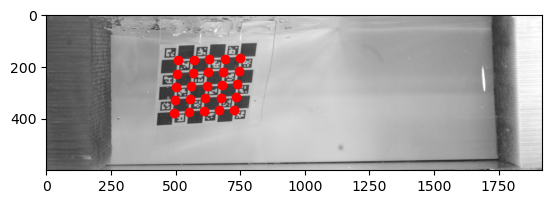

In [7]:
i = 100
fr = rows[i]['framenum']

cap.set(1, fr)
ret, frame = cap.read()

fig, ax = plt.subplots()
ax.imshow(frame)
ax.plot(rows[i]['corners'][:,0,0], rows[i]['corners'][:,0,1], 'ro')

Don't forget to run the code block below to close the video file.

In [8]:
cap.release()

## Calibrate based on all the videos

This will run through all of the videos and detect the corners, then do the calibration and save it out as a `.toml` file

In [215]:
vidnames = [[os.path.join(videopath, fn)] for fn in videonames]
camnames = ['camA', 'camB', 'camC']
ncams = len(vidnames)

camgroup = aniposelib.cameras.CameraGroup.from_names(camnames)

Run the `aniposelib` functions to calibrate based on the videos, and save out the calibration.

In [216]:
err, points = camgroup.calibrate_videos(vidnames, board)
camgroup.dump('calibration.toml')

/Users/etytel01/Documents/2024/StephenAcceleration/sleap/Pumpkinseed/11.15.23/11.15.23Calibration/Charuco_camA.mp4


  0%|                                        | 0/1302 [00:00<?, ?it/s]

100%|█████████████████████████████| 1302/1302 [00:50<00:00, 25.74it/s]


1302 boards detected
/Users/etytel01/Documents/2024/StephenAcceleration/sleap/Pumpkinseed/11.15.23/11.15.23Calibration/Charuco_camB.mp4


100%|█████████████████████████████| 1302/1302 [01:04<00:00, 20.08it/s]


1302 boards detected
/Users/etytel01/Documents/2024/StephenAcceleration/sleap/Pumpkinseed/11.15.23/11.15.23Calibration/Charuco_camC.mp4


100%|█████████████████████████████| 1302/1302 [00:52<00:00, 24.66it/s]


729 boards detected
[{'name': 'camA', 'size': [1920, 600], 'matrix': [[4693.512622685257, 0.0, 959.5], [0.0, 4693.512622685257, 299.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}, {'name': 'camB', 'size': [1920, 800], 'matrix': [[3714.2492834914237, 0.0, 959.5], [0.0, 3714.2492834914237, 399.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}, {'name': 'camC', 'size': [2112, 800], 'matrix': [[4428.66570789724, 0.0, 1055.5], [0.0, 4428.66570789724, 399.5], [0.0, 0.0, 1.0]], 'distortions': [0.0, 0.0, 0.0, 0.0, 0.0], 'rotation': [0.0, 0.0, 0.0], 'translation': [0.0, 0.0, 0.0]}]
defaultdict(<class 'int'>,
            {('camA', 'camB'): 1302,
             ('camA', 'camC'): 706,
             ('camB', 'camA'): 1302,
             ('camB', 'camC'): 706,
             ('camC', 'camA'): 706,
             ('camC', 'camB'): 706})
error:  7.38948661553

Final error above should be around 1. If it's larger than that, use the blocks below to look at the points and try to debug

In [217]:
boardpts = []
for pts1, cam1 in zip(points, camnames):
    col_idx = pd.MultiIndex.from_tuples([[cam1, 'X'], [cam1, 'Y']])
    colnames = [f'X{cam1}', f'Y{cam1}']

    idx = np.empty((0,2))
    c = []
    for frdata in pts1:
        if frdata['corners'].shape[0] == 0:
            next

        c.append(frdata['corners'].reshape((-1, 2)))

        idx1 = np.empty((frdata['ids'].shape[0], 2))
        idx1[:,0] = frdata['framenum'][1]
        idx1[:,1] = frdata['ids'][:,0]

        idx = np.row_stack((idx, idx1))

    idx = pd.MultiIndex.from_arrays([idx[:,0], idx[:,1]], names=['frame', 'point'])

    boardpts.append(pd.DataFrame(np.concatenate(c), index=idx, columns=col_idx))

# only keep the matching points (same frame and id)
boardpts = pd.concat(boardpts, axis=1, join='inner')
    

In [218]:
boardpts.head()

camA                    camB                    camC  \
                      X           Y           X           Y           X   
frame point                                                               
60.0  3.0    670.199402  269.016266  736.974365  312.623413  890.911682   
      4.0    666.634521  323.140198  742.991638  372.215790  882.770325   
      9.0    609.444641  327.372009  681.988647  376.928955  820.185730   
      14.0   551.303345  331.886963  621.173035  381.702820  757.774475   
      15.0   503.531708  112.975670  532.887329  146.782181  736.813232   

                         
                      Y  
frame point              
60.0  3.0    532.961975  
      4.0    559.870667  
      9.0    536.004700  
      14.0   512.106567  
      15.0   391.720947

In [219]:
boardptsmatrix = boardpts.to_numpy().reshape((-1, 3, 2))
boardptsmatrix = boardptsmatrix.transpose((1,0,2)).astype(np.float64)
print(boardptsmatrix.shape)

(3, 16736, 2)


In [220]:
boardpts3d = camgroup.triangulate(boardptsmatrix, progress=True, undistort=True)

100%|█████████████████████████| 16736/16736 [00:05<00:00, 3076.22it/s]


In [221]:
col_idx = pd.MultiIndex.from_product([['3D'], ['X', 'Y', 'Z']])
dfboardpts3d = pd.concat((boardpts, pd.DataFrame(boardpts3d, index=boardpts.index, columns=col_idx)), axis=1)

In [222]:
boardreproj = camgroup.project(boardpts3d)
boardreproj = boardreproj.transpose((1,0,2))
boardreproj = boardreproj.reshape((-1, 6))
boardreproj.shape

(16736, 6)

In [223]:
col_idx = pd.MultiIndex.from_product([camnames, ['Xr', 'Yr']])
dfboardpts3d = pd.concat((dfboardpts3d, pd.DataFrame(boardreproj, index=boardpts.index, columns=col_idx)), axis=1)
dfboardpts3d.head()

camA                    camB                    camC  \
                      X           Y           X           Y           X   
frame point                                                               
60.0  3.0    670.199402  269.016266  736.974365  312.623413  890.911682   
      4.0    666.634521  323.140198  742.991638  372.215790  882.770325   
      9.0    609.444641  327.372009  681.988647  376.928955  820.185730   
      14.0   551.303345  331.886963  621.173035  381.702820  757.774475   
      15.0   503.531708  112.975670  532.887329  146.782181  736.813232   

                                 3D                                camA  \
                      Y           X          Y            Z          Xr   
frame point                                                               
60.0  3.0    532.961975 -116.862979 -17.331431  1884.123040  678.566009   
      4.0    559.870667 -119.526651   5.034547  1892.266368  676.793024   
      9.0    536.004700 -142.061001   5.935269  1882.846615  619.155423   
      14.0   512.106567 -164.475379   6.902272  1873.447876  560.591957   
      15.0   391.720947 -176.079059 -80.195840  1832.554606  504.305398   

                               camB                    camC              
                     Yr          Xr          Yr          Xr          Yr  
frame point                                                              
60.0  3.0    267.963432  733.840138  312.967356  884.774658  533.860206  
      4.0    323.270287  739.763332  371.088757  874.629635  560.673952  
      9.0    327.743477  677.649664  375.569127  813.655572  537.281784  
      14.0   332.461675  615.713946  380.203226  752.815137  513.916493  
      15.0   109.452474  525.553748  150.959956  742.201743  395.232710

In [224]:
board_reproj_err = camgroup.reprojection_error(boardpts3d, boardptsmatrix, mean=False)
errors_norm = np.linalg.norm(board_reproj_err, axis=2)

In [225]:
np.median(errors_norm, axis=1)

array([4.18542567, 2.30258699, 4.10349986])

In [226]:
cap = [cv2.VideoCapture(vn1[0]) for vn1 in vidnames]

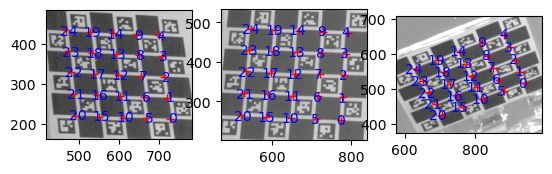

In [229]:
fr = 100

if (fr in dfboardpts3d.index.get_level_values('frame')):
    fig, ax = plt.subplots(ncols=len(cap), nrows=1) #, sharex=True, sharey=True)

    for cam1, cap1, ax1 in zip(camnames, cap, ax):
        cap1.set(1, fr)
        ret, frame1 = cap1.read()

        ax1.imshow(frame1)

        x1 = dfboardpts3d.loc[(fr, slice(None)), (cam1, 'X')]
        y1 = dfboardpts3d.loc[(fr, slice(None)), (cam1, 'Y')]
        xr1 = dfboardpts3d.loc[(fr, slice(None)), (cam1, 'Xr')]
        yr1 = dfboardpts3d.loc[(fr, slice(None)), (cam1, 'Yr')]

        for p1, x11,y11 in zip(x1.index.get_level_values('point'), x1,y1):
            ax1.text(x11, y11, str(int(p1)), horizontalalignment='center',
                     verticalalignment='center', color='b')
        #ax1.plot(x1,y1, 'ro')
        ax1.plot(xr1,yr1, 'r+')

        xx = dfboardpts3d.loc[(fr, slice(None)), (cam1, ['X','Xr'])].stack()
        yy = dfboardpts3d.loc[(fr, slice(None)), (cam1, ['Y','Yr'])].stack()

        ax1.set_xlim(pd.concat([xx.min(), xx.max()]).to_numpy() + np.array([-50, 50]))
        ax1.set_ylim(pd.concat([yy.min(), yy.max()]).to_numpy() + np.array([-50, 50]))

In [230]:
for cap1 in cap:
    cap1.release()

# Load in the Sleap data files

In [135]:
from sleap.io.dataset import Labels

Load the calibration we did above. Make sure the file name is correct!

In [136]:
camgroup = aniposelib.cameras.CameraGroup.load('calibration.toml')

Fill in the names of your cameras and the names of the Sleap `.slp` data files. You should have the same number of Sleap files as you do cameras. But if you trained the same network for multiple views, just repeat the name of the `.slp` file.

Note that the videos need to have matching names across the cameras. So you should have something like:
* test1_camA.mp4, test1_camB.mp4, test1_camC.mp4

or

* camA_test1.mp4, camB_test1.mp4, camC_test1.mp4

or something like that.

In [137]:
camnames = ["camA", "camB", "camC"]

sleapfiles = ["Raw data/SeparateCameras/CamA/BigSLEAPturningTraining-camA.slp",
            "Raw data/SeparateCameras/CamB&C/BigSLEAPturningTraining-camB&C.slp",
            "Raw data/SeparateCameras/CamB&C/BigSLEAPturningTraining-camB&C.slp"]

Load in the Sleap data files

In [138]:
labels = [Labels.load_file(fn) for fn in sleapfiles]

node_count = len(labels[0].skeletons[0].nodes)
node_names = [node.name for node in labels[0].skeletons[0].nodes]

videos = [[v1.backend.filename for v1 in l1.videos if re.search(c1, v1.backend.filename) is not None] for l1, c1 in zip(labels, camnames)]

Function to separate the name of a video and the camera names, so that we can match up videos for different cameras.

In [139]:
def separate_video_and_camera(vidname, camnames):
    fn1 = re.sub(r'\\', '/', vidname)
    fn1 = os.path.basename(fn1)

    for cam1 in camnames:
        fn1, nsub = re.subn(cam1, 'CAMERA', fn1)
        if nsub == 1:
            matched_camera = cam1
            break
    else:
        matched_camera = None

    return fn1, matched_camera

Pull out the $x$ and $y$ coordinates from the Sleap data files and match the same point in the same frame across cameras.

In [161]:
nodenames = [n.name for n in labels[0].skeletons[0].nodes]

ptsall = []
for l1, cam1 in zip(labels, camnames):
    pts = []
    for v1 in l1.videos:
        vidname1, camname1 = separate_video_and_camera(v1.backend.filename, camnames)
        if camname1 != cam1:
            continue
        
        frames = l1.get(v1)
        frame_idx = [lf.frame_idx for lf in frames]

        col_ind = pd.MultiIndex.from_product([[camname1], ['x', 'y']],
                                             names = ['camera', 'point'])
        row_ind = pd.MultiIndex.from_product([[vidname1], frame_idx, nodenames], 
                                             names = ['video', 'frame', 'node'])

        pts1 = pd.DataFrame(index = row_ind, columns=col_ind)

        for lf in frames:
            if len(lf.user_instances) == 1:
                inst = lf.user_instances[0]
            elif len(lf.predicted_instances) == 1:
                inst = lf.predicted_instances[0]
            else:
                print("Error!")
                assert(False)
            
            pts1.loc[(vidname1, lf.frame_idx, slice(None)), (camname1, slice(None))] = inst.numpy()

        pts.append(pts1)
    
    ptsall.append(pd.concat(pts, axis=0))

ptsall = pd.concat(ptsall, axis=1)

In [162]:
ptsall.head()

camera                                                          camA  \
point                                                              x   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           707.526168   
                                          GillCenterLow       748.02   
                                          PelvFinsCenter  781.178769   
                                          MidPelvAnal     807.950671   
                                          AnalBase        818.053275   

camera                                                                \
point                                                              y   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           194.342777   
                                          GillCenterLow       222.92   
                                          PelvFinsCenter  227.122296   
                                          MidPelvAnal     225.924293   
                                          AnalBase        225.924293   

camera                                                           camB  \
point                                                               x   
video                               frame node                          
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout               1252.28   
                                          GillCenterLow        1340.9   
                                          PelvFinsCenter      1398.11   
                                          MidPelvAnal     1435.700043   
                                          AnalBase        1471.253292   

camera                                                                \
point                                                              y   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout               498.26   
                                          GillCenterLow       491.06   
                                          PelvFinsCenter      491.36   
                                          MidPelvAnal     483.431097   
                                          AnalBase        481.959874   

camera                                                           camC  \
point                                                               x   
video                               frame node                          
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           1025.193042   
                                          GillCenterLow       1103.15   
                                          PelvFinsCenter   1141.59631   
                                          MidPelvAnal     1122.599477   
                                          AnalBase        1196.597994   

camera                                                                
point                                                              y  
video                               frame node                        
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout            416.56818  
                                          GillCenterLow       404.17  
                                          PelvFinsCenter  400.452633  
                                          MidPelvAnal     404.822813  
                                          AnalBase        395.610202

Reshape the DataFrame into a 3D numpy matrix. Should have shape $C \times N \times 2$, where $C$ is the number of cameras, $N$ is the number of points, and 2 is for $x$ and $y$ coordinates.

In [163]:
ptsmatrix = ptsall.to_numpy().reshape((-1, 3, 2))
ptsmatrix = ptsmatrix.transpose((1,0,2)).astype(np.float64)
print(ptsmatrix.shape)

(3, 2898, 2)


Show the first point in each camera so that we can compare to the DataFrame above. Should have x and y in the columns and cameras in the rows.

In [164]:
ptsmatrix[:,0,:]

array([[ 707.526168,  194.342777],
       [1252.28    ,  498.26    ],
       [1025.193042,  416.56818 ]])

Triangulate the points to 3D. NB - it's important to do the undistortion. Without it, we get *terrible* reprojection errors.

In [165]:
pts3d = camgroup.triangulate(ptsmatrix, progress=True, undistort=True)

100%|███████████████████████████| 2898/2898 [00:00<00:00, 2975.60it/s]


In [166]:
reproj = camgroup.project(pts3d)
reproj = reproj.transpose((1,0,2))
reproj = reproj.reshape((-1, 6))
reproj.shape

(2898, 6)

...and compute the reprojection error.

In [167]:
reproj_err = camgroup.reprojection_error(pts3d, ptsmatrix, mean=False)
errors_norm = np.linalg.norm(reproj_err, axis=2)

In [168]:
errors_norm[:,0:5]

array([[ 1.68047637,  0.14213315,  3.64142629, 18.66773313,  2.21700235],
       [ 5.94005711,  3.65465057,  1.87581386, 13.80525487,  4.39023732],
       [ 4.55285816,  2.93272322,  5.13284135, 38.26594489,  4.33334158]])

Now build up the same DataFrame as the original points so that we can merge them all.

First for the 3D points themselves

In [169]:
col_ind = pd.MultiIndex.from_product([['3D'], ['x', 'y', 'z']],
                                        names = ['camera', 'point'])

pts3d = pd.DataFrame(pts3d, index=ptsall.index, columns=col_ind)

...and then for the reprojection error. The original reprojection error gives us errors in both $x$ and $y$, but we're just interested in the distance, so we use `np.linalg.norm` to get the distance and then merge it into a DataFrame

In [170]:
col_ind = pd.MultiIndex.from_product([camnames, ['reproj_err']],
                                        names = ['camera', 'point'])

errors_norm = pd.DataFrame(errors_norm.T, index=ptsall.index, columns=col_ind)

These are the median reprojection errors. Make sure they're not too big.

In [171]:
errors_norm.groupby(level=2).median()

camera,camA,camB,camC
point,reproj_err,reproj_err,reproj_err
node,,,
AnalBase,1.817333,3.383312,3.655082
GillCenterLow,1.688002,3.654855,4.486997
MidAnalBasePeduncle,2.293947,4.113208,3.605914
MidPelvAnal,1.836503,4.559257,5.333551
Peduncle,1.791392,2.989039,3.751766
PelvFinsCenter,1.859327,3.786786,3.541485
Snout,1.194450,3.478373,3.346145


Then we merge all of the data frames so that we have the 2D x and y coordinates and the 3D coordinates with reprojection errors.

In [172]:
ptsall3d = pd.concat((ptsall, errors_norm, pts3d), axis=1)

In [174]:
ptsall3d.head()

camera                                                          camA  \
point                                                              x   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           707.526168   
                                          GillCenterLow       748.02   
                                          PelvFinsCenter  781.178769   
                                          MidPelvAnal     807.950671   
                                          AnalBase        818.053275   

camera                                                                \
point                                                              y   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           194.342777   
                                          GillCenterLow       222.92   
                                          PelvFinsCenter  227.122296   
                                          MidPelvAnal     225.924293   
                                          AnalBase        225.924293   

camera                                                           camB  \
point                                                               x   
video                               frame node                          
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout               1252.28   
                                          GillCenterLow        1340.9   
                                          PelvFinsCenter      1398.11   
                                          MidPelvAnal     1435.700043   
                                          AnalBase        1471.253292   

camera                                                                \
point                                                              y   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout               498.26   
                                          GillCenterLow       491.06   
                                          PelvFinsCenter      491.36   
                                          MidPelvAnal     483.431097   
                                          AnalBase        481.959874   

camera                                                           camC  \
point                                                               x   
video                               frame node                          
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           1025.193042   
                                          GillCenterLow       1103.15   
                                          PelvFinsCenter   1141.59631   
                                          MidPelvAnal     1122.599477   
                                          AnalBase        1196.597994   

camera                                                                \
point                                                              y   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout            416.56818   
                                          GillCenterLow       404.17   
                                          PelvFinsCenter  400.452633   
                                          MidPelvAnal     404.822813   
                                          AnalBase        395.610202   

camera                                                         camA  \
point                                                    reproj_err   
video                               frame node                        
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout            1.680476   
                                          GillCenterLow    0.142133   
                                          PelvFinsCenter   3.641426   
                                          MidPelvAnal     18.667733   
                         

In [178]:
pd.DataFrame(reproj, index=ptsall3d.index, columns=col_idx)

camA  \
                                                                       Xr   
video                               frame node                              
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout                705.882597   
                                          GillCenterLow        748.158449   
                                          PelvFinsCenter       777.810538   
                                          MidPelvAnal          791.708717   
                                          AnalBase             815.999729   
...                                                                   ...   
9.7.22Trial18Turn71BLS-CAMERA.mp4   179   PelvFinsCenter       543.183546   
                                          MidPelvAnal          516.003859   
                                          AnalBase             501.691219   
                                          MidAnalBasePeduncle  474.639934   
                                          Peduncle             452.276810   

                                                                           \
                                                                       Yr   
video                               frame node                              
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout                193.992527   
                                          GillCenterLow        222.952150   
                                          PelvFinsCenter       225.738458   
                                          MidPelvAnal          216.721946   
                                          AnalBase             225.088800   
...                                                                   ...   
9.7.22Trial18Turn71BLS-CAMERA.mp4   179   PelvFinsCenter       313.766230   
                                          MidPelvAnal          309.687299   
                                          AnalBase             307.239172   
                                          MidAnalBasePeduncle  281.480499   
                                          Peduncle             274.213789   

                                                                      camB  \
                                                                        Xr   
video                               frame node                               
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout                1254.680569   
                                          GillCenterLow        1341.089233   
                                          PelvFinsCenter       1399.076672   
                                          MidPelvAnal          1423.541278   
                                          AnalBase             1472.480324   
...                                                                    ...   
9.7.22Trial18Turn71BLS-CAMERA.mp4   179   PelvFinsCenter        943.373590   
                                          MidPelvAnal           889.725426   
                                          AnalBase              861.529854   
                                          MidAnalBasePeduncle   809.286312   
                                          Peduncle              765.816081   

                                                                           \
                                                                       Yr   
video                               frame node                              
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout                503.693373   
                                          GillCenterLow        494.709748   
                                          PelvFinsCenter       492.967552   
                                          MidPelvAnal          489.969408   
                                          AnalBase             486.175153   
...                                                                   ...   
9.7.22Trial18Turn71BLS-CAMERA.mp4   179   PelvFinsCenter       255.402211   
                                          MidPel

In [179]:
col_idx = pd.MultiIndex.from_product([camnames, ['Xr', 'Yr']])
ptsall3d = pd.concat((ptsall3d, pd.DataFrame(reproj, index=ptsall3d.index, columns=col_idx)), axis=1)
ptsall3d.head()

camA  \
                                                                   x   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           707.526168   
                                          GillCenterLow       748.02   
                                          PelvFinsCenter  781.178769   
                                          MidPelvAnal     807.950671   
                                          AnalBase        818.053275   

                                                                      \
                                                                   y   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           194.342777   
                                          GillCenterLow       222.92   
                                          PelvFinsCenter  227.122296   
                                          MidPelvAnal     225.924293   
                                          AnalBase        225.924293   

                                                                 camB  \
                                                                    x   
video                               frame node                          
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout               1252.28   
                                          GillCenterLow        1340.9   
                                          PelvFinsCenter      1398.11   
                                          MidPelvAnal     1435.700043   
                                          AnalBase        1471.253292   

                                                                      \
                                                                   y   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout               498.26   
                                          GillCenterLow       491.06   
                                          PelvFinsCenter      491.36   
                                          MidPelvAnal     483.431097   
                                          AnalBase        481.959874   

                                                                 camC  \
                                                                    x   
video                               frame node                          
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout           1025.193042   
                                          GillCenterLow       1103.15   
                                          PelvFinsCenter   1141.59631   
                                          MidPelvAnal     1122.599477   
                                          AnalBase        1196.597994   

                                                                      \
                                                                   y   
video                               frame node                         
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout            416.56818   
                                          GillCenterLow       404.17   
                                          PelvFinsCenter  400.452633   
                                          MidPelvAnal     404.822813   
                                          AnalBase        395.610202   

                                                               camA  \
                                                         reproj_err   
video                               frame node                        
9.5.22Trial14Turn83_5BLS-CAMERA.mp4 99    Snout            1.680476   
                                          GillCenterLow    0.142133   
                                          PelvFinsCenter   3.641426   
                                          MidPelvAnal     18.667733   
                                          AnalBase         2.217002   

                 

And then rearrange the MultiIndexes so that we can save it in a simple CSV format easily.

In [154]:
ptsall3dflat = copy(ptsall3d)
ptsall3dflat.columns = ['_'.join(reversed(c)) for c in ptsall3dflat.columns.to_flat_index()]
ptsall3dflat.reset_index(inplace=True)
ptsall3dflat.head()

,video,frame,node,x_camA,y_camA,x_camB,y_camB,x_camC,y_camC,reproj_err_camA,reproj_err_camB,reproj_err_camC,x_3D,y_3D,z_3D
0,9.5.22Trial14Turn83_5BLS-CAMERA.mp4,99,Snout,707.526168,194.342777,1252.28,498.26,1025.193042,416.56818,1.680476,5.940057,4.552858,35.244019,-29.138225,2694.345175
1,9.5.22Trial14Turn83_5BLS-CAMERA.mp4,99,GillCenterLow,748.02,222.92,1340.9,491.06,1103.15,404.17,0.142133,3.654651,2.932723,60.102369,-12.938602,2692.770513
2,9.5.22Trial14Turn83_5BLS-CAMERA.mp4,99,PelvFinsCenter,781.178769,227.122296,1398.11,491.36,1141.59631,400.452633,3.641426,1.875814,5.132841,77.296924,-11.736161,2692.716297
3,9.5.22Trial14Turn83_5BLS-CAMERA.mp4,99,MidPelvAnal,807.950671,225.924293,1435.700043,483.431097,1122.599477,404.822813,18.667733,13.805255,38.265945,85.172766,-17.147479,2691.830055
4,9.5.22Trial14Turn83_5BLS-CAMERA.mp4,99,AnalBase,818.053275,225.924293,1471.253292,481.959874,1196.597994,395.610202,2.217002,4.390237,4.333342,99.297284,-12.640036,2691.204790


And save! Remember to adjust the file name as needed.

In [99]:
ptsall3dflat.to_csv('points3d.csv', index=False)

## Plot points and reprojected points to check

In [197]:
i = 1000

idx = list(ptsall3d.iloc[i:i+1,:].index[0])
fr = idx[1]

frnames = []
for cam1 in camnames:
    fn1, _ = re.subn('CAMERA', cam1, idx[0])
    frnames.append(fn1)

frnames



['9.7.22Trial14Turn153_5BLS-camA.mp4',
 '9.7.22Trial14Turn153_5BLS-camB.mp4',
 '9.7.22Trial14Turn153_5BLS-camC.mp4']

In [196]:
cap = [cv2.VideoCapture(os.path.join(videopath,fn1)) for fn1 in frnames]

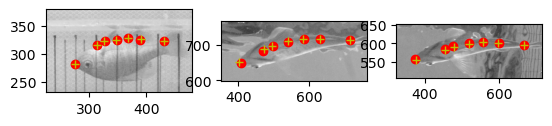

In [212]:
frpts = ptsall3d.loc[(idx[0], idx[1], slice(None))]

fig, ax = plt.subplots(ncols=len(cap), nrows=1) #, sharex=True, sharey=True)

for cam1, cap1, ax1 in zip(camnames, cap, ax):
    cap1.set(1, fr)
    ret, frame1 = cap1.read()

    ax1.imshow(frame1)

    x1 = frpts[(cam1, 'x')]
    y1 = frpts[(cam1, 'y')]
    xr1 = frpts[(cam1, 'Xr')]
    yr1 = frpts[(cam1, 'Yr')]

    ax1.plot(x1,y1, 'ro')
    ax1.plot(xr1,yr1, 'y+')

    xx = frpts.loc[(slice(None)), (cam1, ['x','Xr'])].stack()
    yy = frpts.loc[(slice(None)), (cam1, ['y','Yr'])].stack()

    ax1.set_xlim(pd.concat([xx.min(), xx.max()]).to_numpy() + np.array([-50, 50]))
    ax1.set_ylim(pd.concat([yy.min(), yy.max()]).to_numpy() + np.array([-50, 50]))

In [213]:
for cap1 in cap:
    cap1.release()